In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import warnings
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from math import sqrt
from sklearn.tree import export_graphviz
from graphviz import Source

In [ ]:
# Read entire json file into notebook - takes a minute

df = pd.read_json('/content/drive/MyDrive/Kurt Meyer Data Science Tools 2 Project/weather.json')
#df = pd.read_json('weather.json') # depending on how you load the file.

# Data Preparation

Ultimately I want a dataframe containing daily averages and counts of specific weather criteria. The information I obtained from Open Weather is hourly. So the task will be pulling specific variables from different columns and doing some basic data cleaning.


In [ ]:
df.head(100)

,dt,dt_iso,timezone,main,clouds,weather,wind,lon,city_name,lat,snow,visibility,rain
0,820454400,1996-01-01 00:00:00 +0000 UTC,-21600,"{'temp': 30.24, 'temp_min': 30, 'temp_max': 32...",{'all': 94},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 3.67, 'deg': 58}",-92.897625,55033,44.701494,NaN,NaN,NaN
1,820458000,1996-01-01 01:00:00 +0000 UTC,-21600,"{'temp': 30.45, 'temp_min': 30.22, 'temp_max':...",{'all': 99},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.93, 'deg': 57}",-92.897625,55033,44.701494,NaN,NaN,NaN
2,820461600,1996-01-01 02:00:00 +0000 UTC,-21600,"{'temp': 30.34, 'temp_min': 30.07, 'temp_max':...",{'all': 96},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.5700000000000003, 'deg': 50}",-92.897625,55033,44.701494,NaN,NaN,NaN
3,820465200,1996-01-01 03:00:00 +0000 UTC,-21600,"{'temp': 30.2, 'temp_min': 29.79, 'temp_max': ...",{'all': 100},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.5300000000000002, 'deg': 54}",-92.897625,55033,44.701494,NaN,NaN,NaN
4,820468800,1996-01-01 04:00:00 +0000 UTC,-21600,"{'temp': 30.58, 'temp_min': 30.2, 'temp_max': ...",{'all': 100},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.21, 'deg': 56}",-92.897625,55033,44.701494,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,820796400,1996-01-04 23:00:00 +0000 UTC,-21600,"{'temp': 9.23, 'temp_min': 8.73, 'temp_max': 1...",{'all': 3},"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 6.71, 'deg': 340}",-92.897625,55033,44.701494,NaN,10000.0,NaN
96,820800000,1996-01-05 00:00:00 +0000 UTC,-21600,"{'temp': 11.68, 'temp_min': 4.37, 'temp_max': ...",{'all': 1},"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 5.59, 'deg': 340}",-92.897625,55033,44.701494,NaN,10000.0,NaN
97,820803600,1996-01-05 01:00:00 +0000 UTC,-21600,"{'temp': 7.09, 'temp_min': 4.37, 'temp_max': 1...",{'all': 0},"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 6.71, 'deg': 340}",-92.897625,55033,44.701494,NaN,10000.0,NaN
98,820807200,1996-01-05 02:00:00 +0000 UTC,-21600,"{'temp': 6.28, 'temp_min': 3.29, 'temp_max': 9...",{'all': 0},"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 8.05, 'deg': 340}",-92.897625,55033,44.701494,NaN,10000.0,NaN


In [ ]:
# This cell converts the data column to a date datatype and also selects the dates we're interested in
#at the end we drop the original dt column and get "filtered_df"

df['dt_iso_cleaned'] = df['dt_iso'].apply(lambda x: x.replace(' +0000 UTC', ''))

# Now, convert the cleaned dt_iso column to datetime
df['dt_iso_cleaned'] = pd.to_datetime(df['dt_iso_cleaned'])

# If we want to select start and end dates this can be done here.
# I did this project in the cloud on a high RAM CPU. If you run this locally it might be a good idea to only use a portion of the data depending on your machine's specs!
# If you change the dates comment out this line below: row_index = combined_df[combined_df['datetime'] == '1995-12-31'].index[0]
start_date = pd.Timestamp('1996-01-01')
end_date = pd.Timestamp('2024-02-03')

filtered_df = df[(df['dt_iso_cleaned'].dt.date >= start_date.date()) & (df['dt_iso_cleaned'].dt.date <= end_date.date())]




In [ ]:
filtered_df.head()

,dt,dt_iso,timezone,main,clouds,weather,wind,lon,city_name,lat,snow,visibility,rain,dt_iso_cleaned
0,820454400,1996-01-01 00:00:00 +0000 UTC,-21600,"{'temp': 30.24, 'temp_min': 30, 'temp_max': 32...",{'all': 94},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 3.67, 'deg': 58}",-92.897625,55033,44.701494,NaN,NaN,NaN,1996-01-01 00:00:00
1,820458000,1996-01-01 01:00:00 +0000 UTC,-21600,"{'temp': 30.45, 'temp_min': 30.22, 'temp_max':...",{'all': 99},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.93, 'deg': 57}",-92.897625,55033,44.701494,NaN,NaN,NaN,1996-01-01 01:00:00
2,820461600,1996-01-01 02:00:00 +0000 UTC,-21600,"{'temp': 30.34, 'temp_min': 30.07, 'temp_max':...",{'all': 96},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.5700000000000003, 'deg': 50}",-92.897625,55033,44.701494,NaN,NaN,NaN,1996-01-01 02:00:00
3,820465200,1996-01-01 03:00:00 +0000 UTC,-21600,"{'temp': 30.2, 'temp_min': 29.79, 'temp_max': ...",{'all': 100},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.5300000000000002, 'deg': 54}",-92.897625,55033,44.701494,NaN,NaN,NaN,1996-01-01 03:00:00
4,820468800,1996-01-01 04:00:00 +0000 UTC,-21600,"{'temp': 30.58, 'temp_min': 30.2, 'temp_max': ...",{'all': 100},"[{'id': 804, 'main': 'Clouds', 'description': ...","{'speed': 2.21, 'deg': 56}",-92.897625,55033,44.701494,NaN,NaN,NaN,1996-01-01 04:00:00


In [ ]:
# The main column has a lot of relevant values. These need to be extracted. Each row has a dictionary

# Directly access the full data from the first cell of main column
cell_data = df.loc[0, 'main']

# Print the full data to assess structure
print(cell_data)


{'temp': 30.24, 'temp_min': 30, 'temp_max': 32.14, 'feels_like': 26.44, 'pressure': 1012, 'humidity': 93, 'dew_point': 28.67}


In [ ]:
#These lambda functions grab the information we want from the main column
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    filtered_df['temp'] = filtered_df['main'].apply(lambda x: x.get('temp'))
    filtered_df['temp_min'] = filtered_df['main'].apply(lambda x: x.get('temp_min'))
    filtered_df['temp_max'] = filtered_df['main'].apply(lambda x: x.get('temp_max'))
    filtered_df['feels_like'] = filtered_df['main'].apply(lambda x: x.get('feels_like'))
    filtered_df['pressure'] = filtered_df['main'].apply(lambda x: x.get('pressure'))
    filtered_df['humidity'] = filtered_df['main'].apply(lambda x: x.get('humidity'))
    filtered_df['dew_point'] = filtered_df['main'].apply(lambda x: x.get('dew_point'))
    filtered_df['wind_speed'] = filtered_df['wind'].apply(lambda x: x.get('speed'))
    filtered_df['wind_direction'] = filtered_df['wind'].apply(lambda x: x.get('deg'))



In [ ]:
#Drop the main and visibility columns
filtered_df = filtered_df.drop(columns=['main'])
filtered_df = filtered_df.drop(columns=['visibility'])


In [ ]:
#Checking the weather column we see relevant information
# Open weather has codes for particular weather conditions - later we will count these for the models
# This is a list with a dictionary inside it
cell_data = df.loc[0, 'weather']
# Print the full data with type

print(cell_data)
type(cell_data)

[{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}]


list

In [ ]:
#Same as above but had to change the lambda functions so they could access the dictionaries within the lists
filtered_df['id'] = filtered_df['weather'].apply(lambda x: x[0]['id'] if x else None)
filtered_df['short_description'] = filtered_df['weather'].apply(lambda x: x[0]['main'] if x else None)
filtered_df['long_description'] = filtered_df['weather'].apply(lambda x: x[0]['description'] if x else None)



In [ ]:
# If there is no snow or rain the dataset has no information. Would like to keep these continuous so changed all NaNs to 0s

filtered_df['snow'] = filtered_df['snow'].fillna(0)
filtered_df['rain'] = filtered_df['rain'].fillna(0)

In [ ]:
filtered_df['datetime'] = pd.to_datetime(filtered_df['dt'], unit='s')
filtered_df['datetime'] = filtered_df['datetime'] + pd.to_timedelta(filtered_df['timezone'], unit='s')

In [ ]:
filtered_df['weather_id'] = filtered_df['weather'].apply(lambda x: x[0]['id'])
#After this step I checked column data types for more info on how to handle data prep

In [ ]:
# Function to extract precipitation value from a dictionary - already took care of NaNs
def extract_precipitation_value(x):
    if isinstance(x, dict):
        return x.get('1h', 0)
    else:
        return x

filtered_df['snow'] = filtered_df['snow'].apply(extract_precipitation_value)
filtered_df['rain'] = filtered_df['rain'].apply(extract_precipitation_value)





In [ ]:
# Convert wind direction from degrees to radians and trasnform with sine and cosine for direct use in models
filtered_df['wind_direction_rad'] = np.radians(filtered_df['wind_direction'])
filtered_df['wind_direction_sin'] = np.sin(filtered_df['wind_direction_rad'])
filtered_df['wind_direction_cos'] = np.cos(filtered_df['wind_direction_rad'])


In [ ]:
#filtered_df.head(5)

In [ ]:
ml_df = filtered_df.drop(columns=[
    'timezone',
    'clouds',
    'weather',
    'wind',
    'lon',
    'lat',
    'city_name',
    'short_description',
    'long_description'
])


In [ ]:
#ml_df.head(5)

In [ ]:
#Adding weather ID descriptions
def categorize_weather(weather_id):
    if 200 <= weather_id <= 232:
        return 'Thunderstorm'
    elif 300 <= weather_id <= 321:
        return 'Drizzle'
    elif 500 <= weather_id <= 531:
        return 'Rain'
    elif 600 <= weather_id <= 622:
        return 'Snow'
    elif 701 <= weather_id <= 781:
        return 'Atmosphere'
    elif weather_id == 800:
        return 'Clear'
    elif 801 <= weather_id <= 804:
        return 'Clouds'
    else:
        return 'Other'

# Apply the categorization function to each weather ID
ml_df['weather_category'] = ml_df['id'].apply(categorize_weather)

# Group by date and weather category, then count occurrences
daily_weather_counts = ml_df.groupby(['datetime', 'weather_category']).size().unstack(fill_value=0)

#Details on these IDs can be found here: https://openweathermap.org/weather-conditions

In [ ]:
#ml_df.head()

In [ ]:

ml_df = ml_df.drop(columns=['dt', 'dt_iso', 'dt_iso_cleaned', 'feels_like', 'id', 'wind_direction', 'weather_id','weather_category'])
ml_df.head(2)


,snow,rain,temp,temp_min,temp_max,pressure,humidity,dew_point,wind_speed,datetime,wind_direction_rad,wind_direction_sin,wind_direction_cos
0,0.0,0.0,30.24,30.00,32.14,1012,93,28.67,3.67,1995-12-31 18:00:00,1.012291,0.848048,0.529919
1,0.0,0.0,30.45,30.22,32.14,1013,93,28.89,2.93,1995-12-31 19:00:00,0.994838,0.838671,0.544639


In [ ]:
ml_df.isnull().sum()  # Check for missing values and good to go


snow                  0
rain                  0
temp                  0
temp_min              0
temp_max              0
pressure              0
humidity              0
dew_point             0
wind_speed            0
datetime              0
wind_direction_rad    0
wind_direction_sin    0
wind_direction_cos    0
dtype: int64

In [ ]:
ml_df.set_index('datetime', inplace=True)

# Resample the data by day and calculate the mean for each day
daily_averages = ml_df.resample('D').mean()

# Reset the index
daily_averages.reset_index(inplace=True)

# Display the first few rows to verify
daily_averages.head()

,datetime,snow,rain,temp,temp_min,temp_max,pressure,humidity,dew_point,wind_speed,wind_direction_rad,wind_direction_sin,wind_direction_cos
0,1995-12-31,0.0000,0.0,30.323333,29.941667,31.883333,1013.833333,93.833333,28.946667,2.951667,0.962840,0.819976,0.570586
1,1996-01-01,0.0225,0.0,31.000417,29.662500,31.772083,1016.708333,94.041667,29.611250,4.572917,0.768672,0.653717,0.675015
2,1996-01-02,0.0000,0.0,15.219167,13.612083,17.427500,1023.125000,78.458333,10.305417,8.257500,2.090032,0.244944,0.914187
3,1996-01-03,0.0000,0.0,2.807917,0.520417,4.945000,1014.375000,85.708333,-0.200417,3.112917,1.270454,0.526687,0.113422
4,1996-01-04,0.0000,0.0,7.003333,5.728750,9.919583,1022.625000,78.958333,2.352083,5.227083,2.812162,0.149302,0.849126


In [ ]:
# Resample to daily data and sum up the counts for each day
daily_weather_counts_daily = daily_weather_counts.resample('D').sum()



In [ ]:
# Check to make sure it worked.
daily_weather_counts_daily.head(10)

weather_category,Atmosphere,Clear,Clouds,Drizzle,Rain,Snow,Thunderstorm
datetime,,,,,,,
1995-12-31,0,0,6,0,0,0,0
1996-01-01,1,0,20,0,0,3,0
1996-01-02,0,10,14,0,0,0,0
1996-01-03,0,5,19,0,0,0,0
1996-01-04,0,15,9,0,0,0,0
1996-01-05,0,7,16,0,0,1,0
1996-01-06,0,10,14,0,0,0,0
1996-01-07,0,15,9,0,0,0,0
1996-01-08,0,2,21,0,0,1,0


In [ ]:
# Convert 'datetime' to datetime type in daily_averages
daily_averages['datetime'] = pd.to_datetime(daily_averages['datetime'])

# Merging
combined_df = pd.merge(daily_averages, daily_weather_counts, on='datetime', how='left')
combined_df.head()


,datetime,snow,rain,temp,temp_min,temp_max,pressure,humidity,dew_point,wind_speed,wind_direction_rad,wind_direction_sin,wind_direction_cos,Atmosphere,Clear,Clouds,Drizzle,Rain,Snow,Thunderstorm
0,1995-12-31,0.0000,0.0,30.323333,29.941667,31.883333,1013.833333,93.833333,28.946667,2.951667,0.962840,0.819976,0.570586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-01-01,0.0225,0.0,31.000417,29.662500,31.772083,1016.708333,94.041667,29.611250,4.572917,0.768672,0.653717,0.675015,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1996-01-02,0.0000,0.0,15.219167,13.612083,17.427500,1023.125000,78.458333,10.305417,8.257500,2.090032,0.244944,0.914187,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1996-01-03,0.0000,0.0,2.807917,0.520417,4.945000,1014.375000,85.708333,-0.200417,3.112917,1.270454,0.526687,0.113422,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1996-01-04,0.0000,0.0,7.003333,5.728750,9.919583,1022.625000,78.958333,2.352083,5.227083,2.812162,0.149302,0.849126,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#I'm filling these in due to index error. I checked the original data and everything still lines up.
row_index = combined_df[combined_df['datetime'] == '1995-12-31'].index[0]
combined_df.at[row_index, 'Atmosphere'] = 0
combined_df.at[row_index, 'Clear'] = 0
combined_df.at[row_index, 'Clouds'] = 6
combined_df.at[row_index, 'Drizzle'] = 0
combined_df.at[row_index, 'Rain'] = 0
combined_df.at[row_index, 'Snow'] = 0
combined_df.at[row_index, 'Thunderstorm'] = 0

In [ ]:
#No nulls double check
#combined_df.isnull().sum()

I decided to engineer a feature for daylength. Minnesota has very short and very long days. It might amount to nothing but I'm curious to see if daylength matters at all. I found an open source function on Github Gist by Googling and provide attribution below.

In [ ]:
import numpy as np

def daylength(dayOfYear, lat):
    """
    Computes the length of the day (the time between sunrise and sunset)
    given the day of the year and latitude of the location. Function uses
    the Brock model for the computations. For more information see, for example,
    Forsythe et al., "A model comparison for daylength as a function of latitude
    and day of year", Ecological Modelling, 1995.

    Parameters
    ----------
    dayOfYear : int
        The day of the year. 1 corresponds to 1st of January
        and 365 to 31st December (on a non-leap year).
    lat : float
        Latitude of the location in degrees. Positive values
        for north and negative for south.

    Returns
    -------
    d : float
        Daylength in hours.
    """
    latInRad = np.deg2rad(lat)
    declinationOfEarth = 23.45 * np.sin(np.deg2rad(360.0 * (283.0 + dayOfYear) / 365.0))
    if -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) <= -1.0:
        return 24.0
    elif -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) >= 1.0:
        return 0.0
    else:
        hourAngle = np.rad2deg(np.arccos(-np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth))))
        return 2.0 * hourAngle / 15.0

#Attribution: https://gist.github.com/anttilipp/ed3ab35258c7636d87de6499475301ce


In [ ]:
# The next two cells test the function.
latitude = 44.701494
longitude = -92.897625
combined_df['daylength'] = combined_df.apply(lambda row: daylength(row['datetime'].timetuple().tm_yday, latitude), axis=1)


In [ ]:
print(daylength(100, 44.701494))
#Checked against real data on timdeanddate.com and is correct within a few minutes.

12.950886673699953


Earlier I experimented with converting degrees into radians. I realized these will not work for a linear model for the same reasons degrees do not work. So I am once again going to add directional values using sine and cosine.

For reference here is what the cosine and sine values mean:

1. Cosine = 1 means that the wind is coming from the north.
2. Cosine = -1 means that the wind is coming from the south.
3. Cosine = 0 means the wind is come either from the east or west.
4. Sine = 1 means that the wind is blowing from the east.
5. Sine = -1 means that the wind is blowing from the west.
6. Sine = 0 means that the wind is blowing from the north or south.

Attribution: [Geeks for Geeks](https://www.geeksforgeeks.org/trigonometry-table/) has a nice summary on how the math works.

In [ ]:
filtered_df['wind_direction_rad'] = np.radians(filtered_df['wind_direction'])
filtered_df['wind_direction_sin'] = np.sin(filtered_df['wind_direction_rad'])
filtered_df['wind_direction_cos'] = np.cos(filtered_df['wind_direction_rad'])
filtered_df = filtered_df.drop(columns=['wind_direction_rad'])



# Exploratory Data Analysis

In this section I will analyze correlations between the different continuous variables and assess the shape of the different variables.

First we'll start off with some summary statistics including average windspeed by direction. Then we'll move on to correlations and density plots.

In [ ]:
# This cell provides averages by direction. This was one of the most helpful EDA features I created.

def categorize_direction(degrees):
    if degrees is None:
        return None
    bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    for i, bin_edge in enumerate(bins):
        if degrees < bin_edge:
            return labels[i-1]
    return 'N'  # Circular data! Handle exactly 360 degrees

filtered_df['wind_direction_cat'] = filtered_df['wind_direction'].apply(categorize_direction)

# Calculate avg wind speed for each wind direction category
avg_wind_speed_by_dir = filtered_df.groupby('wind_direction_cat')['wind_speed'].mean().sort_values(ascending=False)

print(avg_wind_speed_by_dir)

wind_direction_cat
W     7.935451
NW    7.547438
SE    7.136970
E     6.979763
S     6.964487
SW    6.472079
NE    6.009120
N     3.469697
Name: wind_speed, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Sample data
avg_wind_speed_by_dir = {
    'W': 7.935451,
    'NW': 7.547438,
    'SE': 7.136970,
    'E': 6.979763,
    'S': 6.964487,
    'SW': 6.472079,
    'NE': 6.009120,
    'N': 3.469697
}

# Creating DataFrame for plotting
df_wind_speed = pd.DataFrame(list(avg_wind_speed_by_dir.items()), columns=['Direction', 'AvgWindSpeed'])

# Sorting the DataFrame to ensure the wind directions are in the correct order for plotting
order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
df_wind_speed['Direction'] = pd.Categorical(df_wind_speed['Direction'], categories=order, ordered=True)
df_wind_speed = df_wind_speed.sort_values('Direction')

# Values and directions
values = df_wind_speed['AvgWindSpeed'].tolist()
values += values[:1]  # Complete the loop
directions = df_wind_speed['Direction'].tolist()
directions += directions[:1]

# Polar plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=values,
    theta=directions,
    fill='toself',
    name='Avg Wind Speed',
    line=dict(color='navy')
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(values) + 1],
            tickvals=[2, 4, 6, 8],
            ticktext=["2", "4", "6", "8"]
        ),
        angularaxis=dict(
            direction="clockwise",
            rotation=90,
            tickvals=order
        )
    ),
    showlegend=False,
    title=dict(
        text='Avg Wind Speed by Direction',
        y=0.95,
        font=dict(size=15, color='navy')
    ),
    margin=dict(t=50, b=50)
)

fig.show()


In [ ]:
combined_df.tail()

,datetime,snow,rain,temp,temp_min,temp_max,pressure,humidity,dew_point,wind_speed,...,wind_direction_sin,wind_direction_cos,Atmosphere,Clear,Clouds,Drizzle,Rain,Snow,Thunderstorm,daylength
10257,2024-01-30,0.0,0.000000,36.877917,35.589583,38.407083,1015.500000,82.958333,32.190833,4.129167,...,-0.838494,0.205831,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.453068
10258,2024-01-31,0.0,0.000000,39.652917,36.995833,42.103750,1013.708333,86.041667,35.587917,4.104583,...,-0.505176,-0.722317,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.492502
10259,2024-02-01,0.0,0.010417,38.020833,35.077083,41.228333,1013.875000,84.833333,33.672083,4.959167,...,0.149984,0.706968,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.532573
10260,2024-02-02,0.0,0.000000,30.627083,29.036667,32.041250,1018.833333,82.958333,26.312083,5.471250,...,0.850719,-0.125287,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.573263
10261,2024-02-03,0.0,0.000000,33.311111,32.166111,35.051667,1017.444444,81.222222,28.402222,5.860556,...,0.706352,-0.508087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.614551


Pay special attention to the summary stats for wind speed. This will help assess model performance later.

In [ ]:
summary_stats = combined_df.describe()
summary_stats

,datetime,snow,rain,temp,temp_min,temp_max,pressure,humidity,dew_point,wind_speed,...,wind_direction_sin,wind_direction_cos,Atmosphere,Clear,Clouds,Drizzle,Rain,Snow,Thunderstorm,daylength
count,10262,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,...,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000,10262.000000
mean,2010-01-16 12:00:00,0.015544,0.082510,46.773863,44.471979,48.869398,1015.711120,72.268598,37.639915,6.567635,...,-0.100416,0.015918,0.025726,0.369519,0.489671,0.002339,0.075424,0.036153,0.001657,11.987682
min,1995-12-31 00:00:00,0.000000,0.000000,-24.598750,-25.687083,-23.588750,975.833333,20.208333,-32.614167,0.000000,...,-0.997414,-0.997864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.610466
25%,2003-01-08 06:00:00,0.000000,0.000000,30.309896,28.184583,31.979375,1010.750000,64.541667,23.609479,4.296354,...,-0.529961,-0.488081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.698852
50%,2010-01-16 12:00:00,0.000000,0.000000,48.573750,46.320625,50.650417,1015.395833,73.208333,37.351250,6.086250,...,-0.132998,0.035013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.973368
75%,2017-01-24 18:00:00,0.000000,0.027917,66.473958,64.191979,68.764167,1020.416667,81.000000,55.500625,8.388333,...,0.300928,0.525974,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.279727
max,2024-02-03 00:00:00,1.645833,3.153750,89.350833,87.103333,92.396667,1045.875000,100.000000,78.844583,21.566250,...,0.995285,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,15.389534
std,NaN,0.076704,0.232539,21.892881,22.025344,22.138872,7.734033,12.045925,20.353068,3.010794,...,0.514585,0.582315,0.158324,0.482698,0.502833,0.048306,0.264087,0.186679,0.040670,2.344760


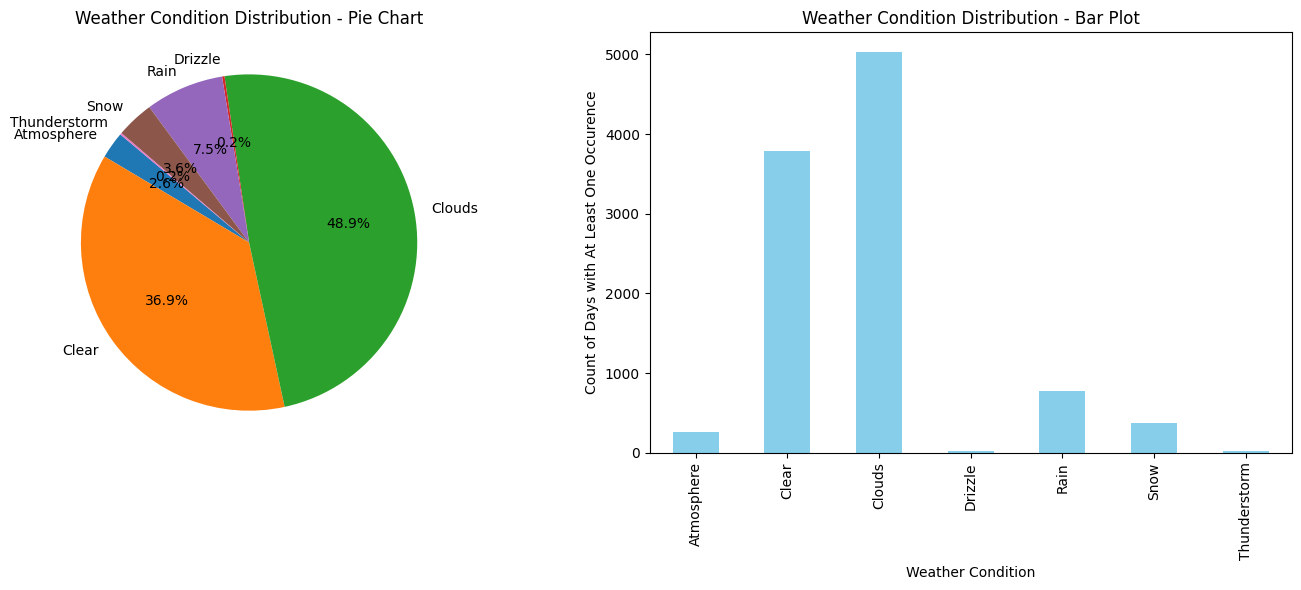

In [ ]:
weather_conditions_summary = combined_df[['Atmosphere', 'Clear', 'Clouds', 'Drizzle', 'Rain', 'Snow', 'Thunderstorm']].sum()

# Re-using the plotting code with the adapted data
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for proportions
ax[0].pie(weather_conditions_summary, labels=weather_conditions_summary.index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Weather Condition Distribution - Pie Chart')

# Bar plot for counts
weather_conditions_summary.plot(kind='bar', ax=ax[1], color='skyblue')
ax[1].set_title('Weather Condition Distribution - Bar Plot')
ax[1].set_ylabel('Count of Days with At Least One Occurence')
ax[1].set_xlabel('Weather Condition')

plt.tight_layout()
plt.show()

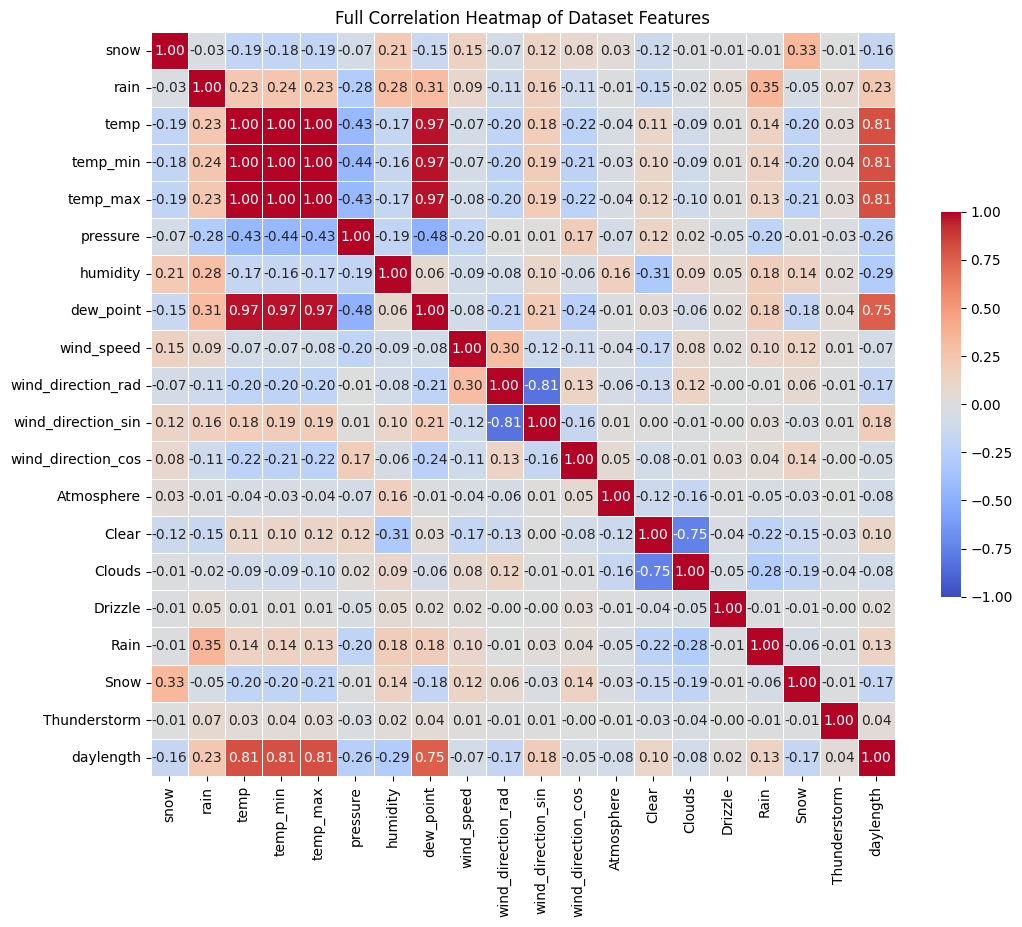

In [ ]:
corr_matrix = combined_df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))

# Draw the full heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Full Correlation Heatmap of Dataset Features')
plt.show()

<ipython-input-40-965ddb589974>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




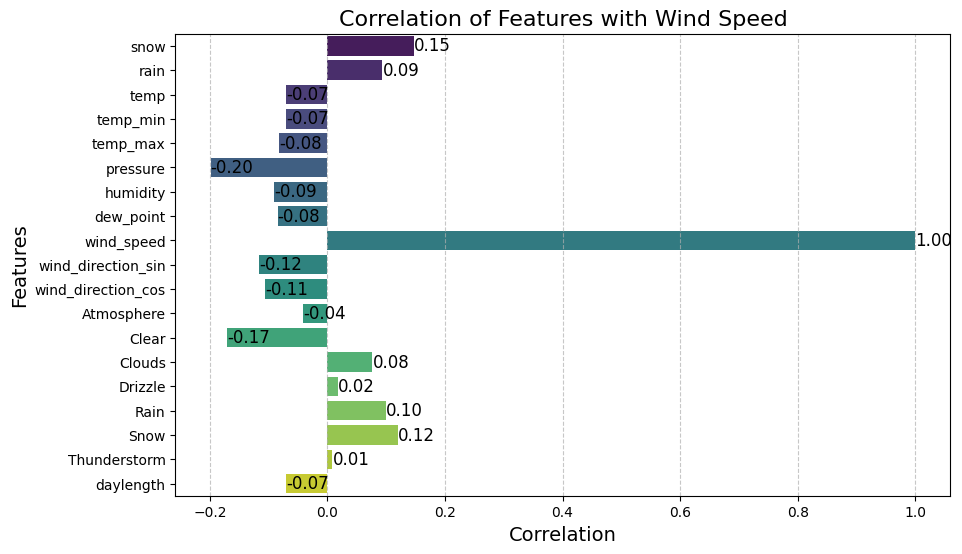

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the correlation matrix to a DataFrame
wind_speed_corrs = pd.Series(corr_matrix['wind_speed'])
wind_speed_corrs_df = wind_speed_corrs.reset_index()
wind_speed_corrs_df.columns = ['Feature', 'Correlation with Wind Speed']

# Drop the 'wind_direction_rad' feature
wind_speed_corrs_df = wind_speed_corrs_df[wind_speed_corrs_df['Feature'] != 'wind_direction_rad']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=wind_speed_corrs_df, x='Correlation with Wind Speed', y='Feature', palette='viridis')

plt.title('Correlation of Features with Wind Speed', fontsize=16)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding value labels on bars
for index, value in enumerate(wind_speed_corrs_df['Correlation with Wind Speed']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center", fontsize=12)

plt.show()



These correlations mostly make sense to me. I had to think about the thunderstorm correlations but I think this the result of there being relatively few thunderstorm events compared to all the others. Counts may not be the best way to incorporate these variables.

The slightly negative correlation with day length suggests seasonality.

Wind direction seems to be an important factor for wind speed. Pressure, humidity, and day length also appear to be important.

Now I will create some density plots for the continuous variables to assess their shape.

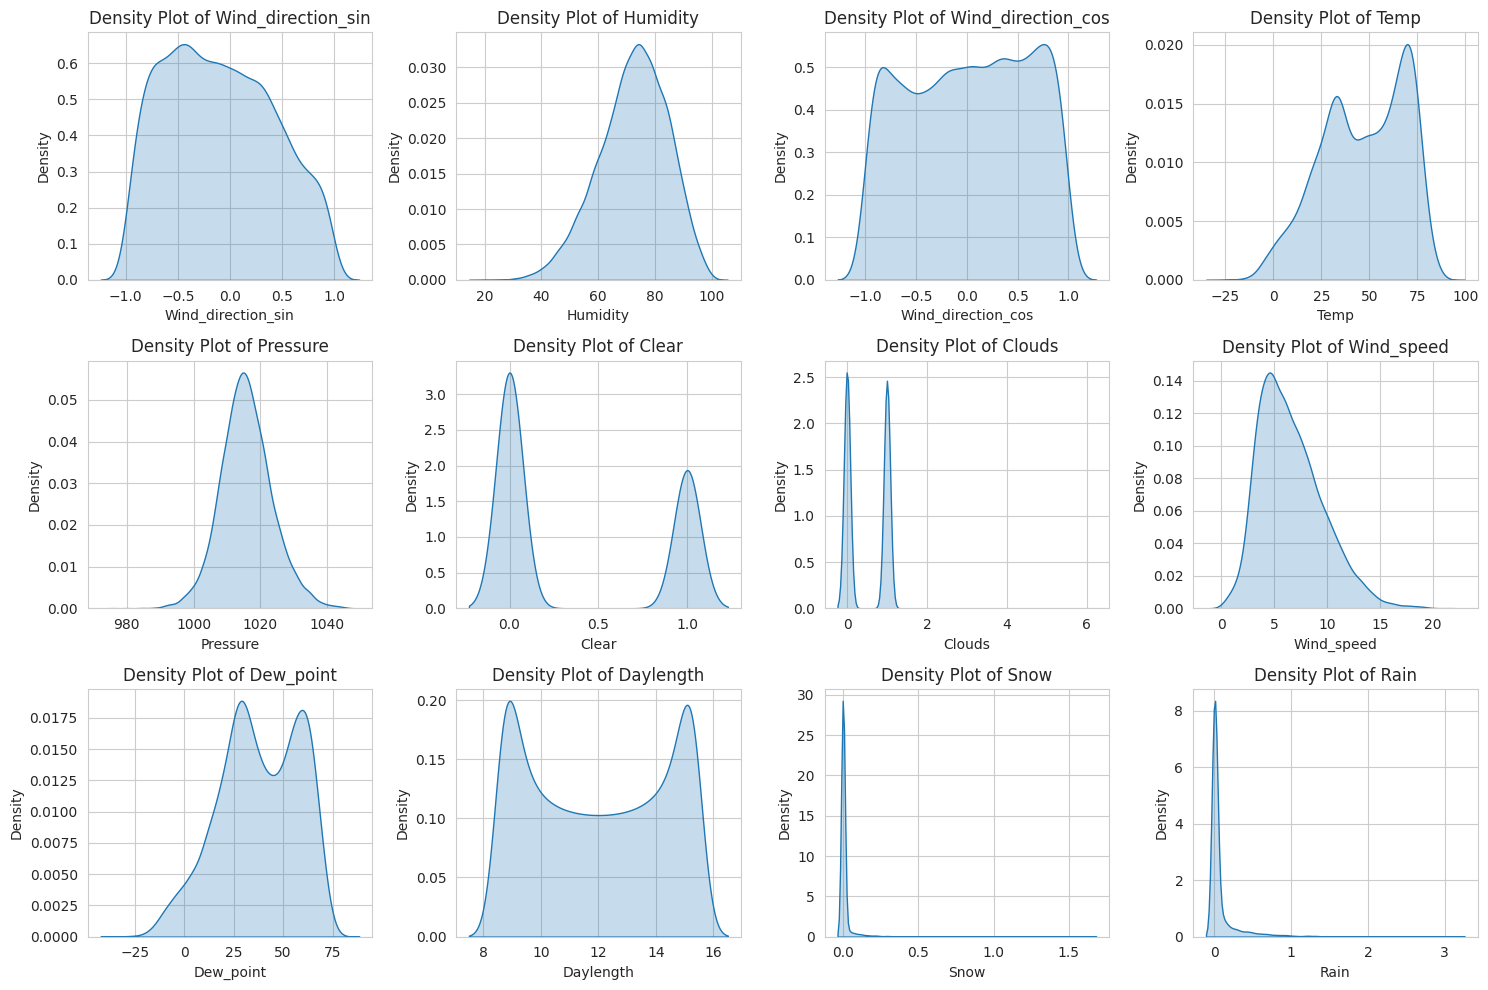

In [ ]:
sns.set_style("whitegrid")

# List of variables for which to create density plots
variables_to_plot = ['wind_direction_sin', 'humidity', 'wind_direction_cos', 'temp', 'pressure', 'Clear', 'Clouds', 'wind_speed', 'dew_point', 'daylength', 'snow', 'rain']

# Figure
plt.figure(figsize=(15, 10))

for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(3, 4, i)  # You can adjust rows and columns to whatever you want here
    sns.kdeplot(combined_df[variable], fill=True)
    plt.title(f'Density Plot of {variable.capitalize()}')
    plt.xlabel(variable.capitalize())
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

This further verifies the daylength function is working properly.

Now I'm looking to see how the data is distributed. Wind speed is right skewed so that will be important to keep in mind.

This along with other information in my EDA makes me question how a linear regression will a perform. Regardless, it will be a good baseline.

At this point, I expect a random forest to perform the best.

I am going to drop couple columns at this point because I don't think they will be helpful. Drizzle, thunderstorm, and atmosphere will all be dropped.



In [ ]:
post_eda_df = combined_df.drop(columns=['Atmosphere', 'Drizzle', 'Thunderstorm', 'wind_direction_rad'])

# Verify the columns have been dropped by displaying the first few rows of the updated DataFrame
#post_eda_df.head(5)

Looks like everything is where I want it. Now time to start modeling.

# Linear Regression

First I will check to ensure it makes sense to perform a linear regression on this data by testing to ensure it fulfills the requirements of linearity, independence, and normality of errors.

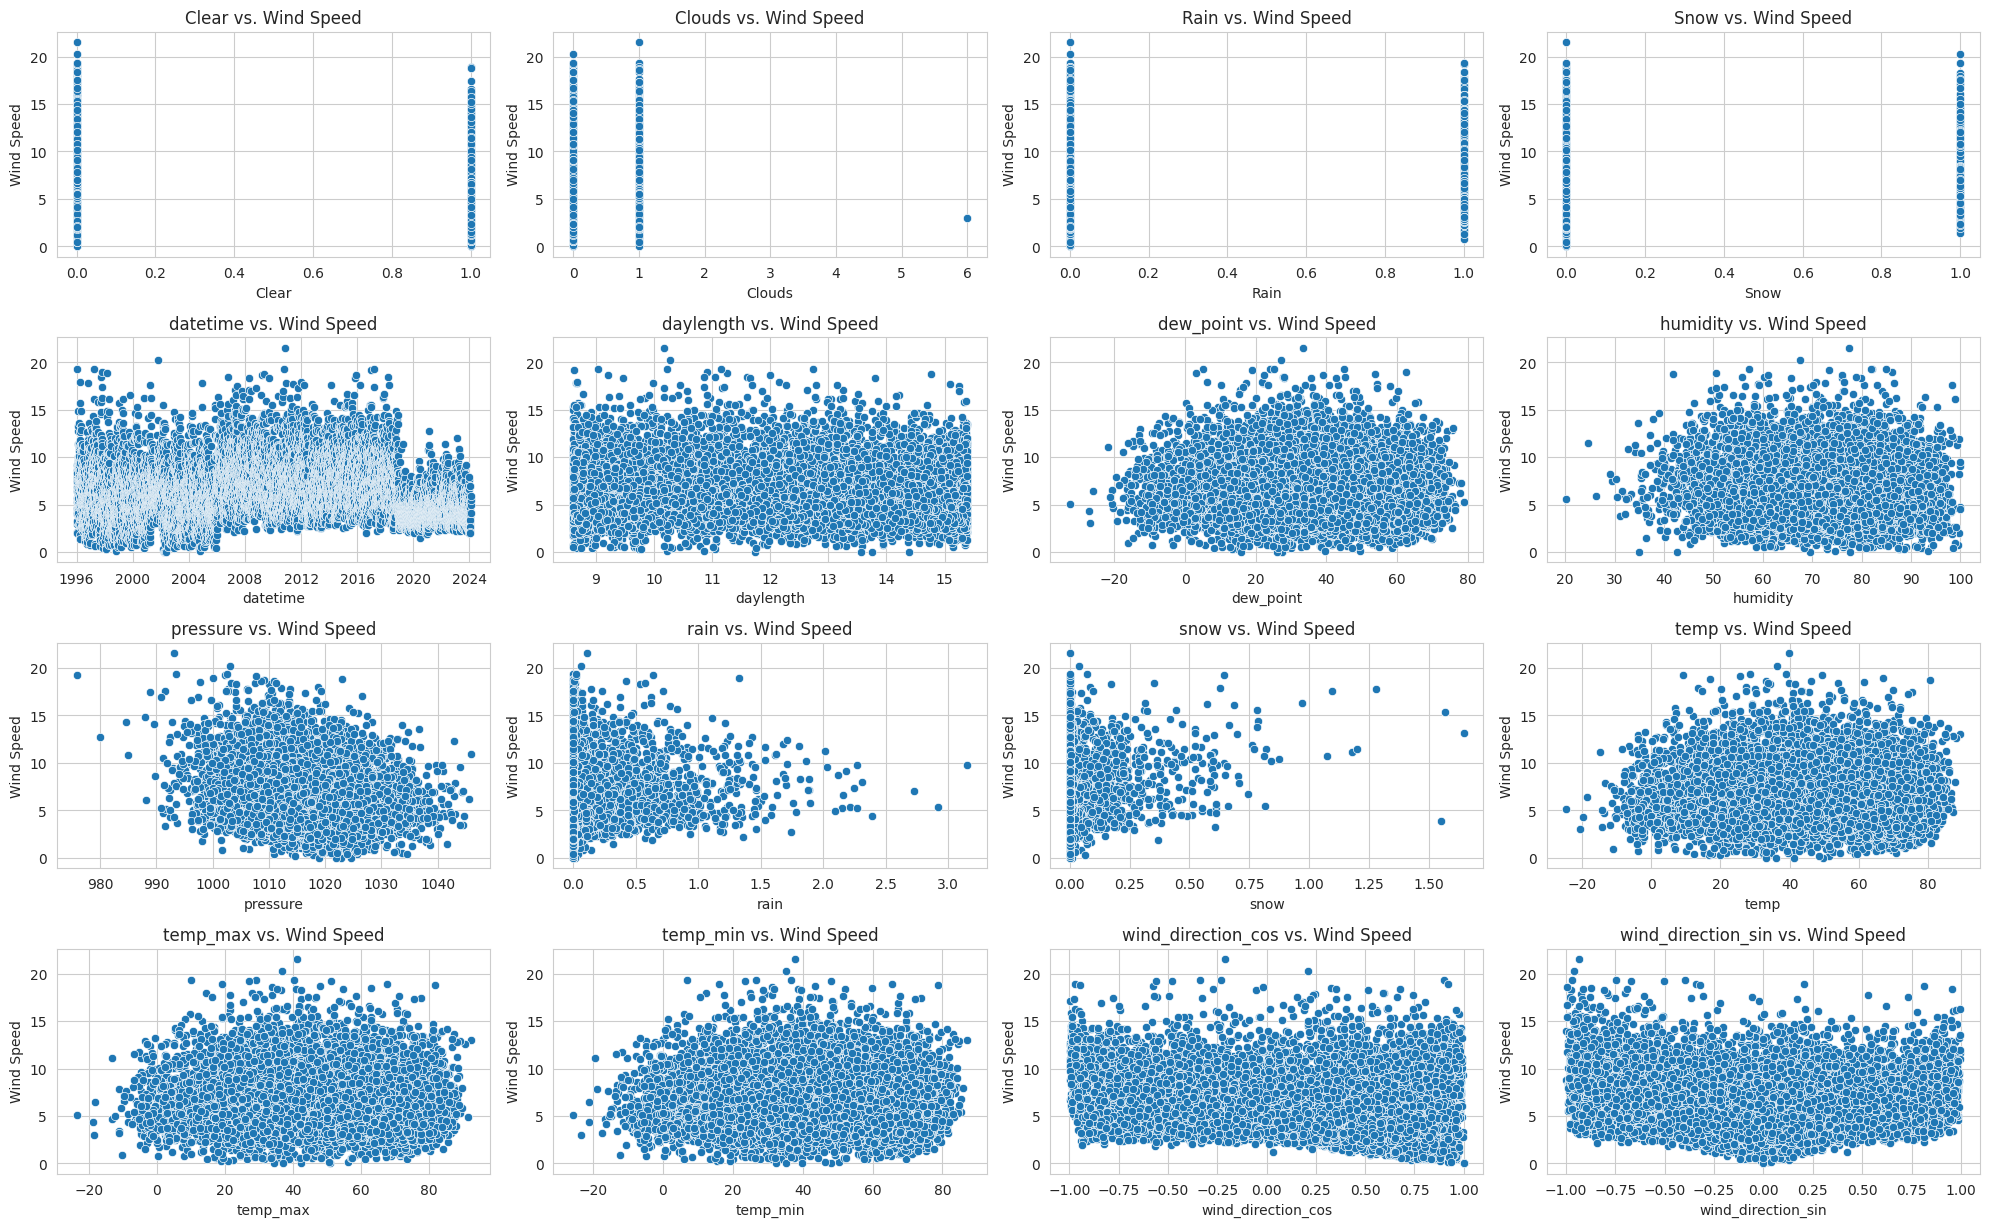

In [ ]:
independent_variables = post_eda_df.columns.difference(['wind_speed'])

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

for i, variable in enumerate(independent_variables, 1):
    # Subplots for different variables
    plt.subplot(5, 4, i)  # Adjust the grid size to whatever you want
    sns.scatterplot(x=post_eda_df[variable], y=post_eda_df['wind_speed'])

    plt.title(f'{variable} vs. Wind Speed')
    plt.xlabel(variable)
    plt.ylabel('Wind Speed')

plt.tight_layout()
plt.show()

Unfortunately, not all of these are linear with wind speed. Now let's use OLS to generate a simple residual plot so we can see the shape.

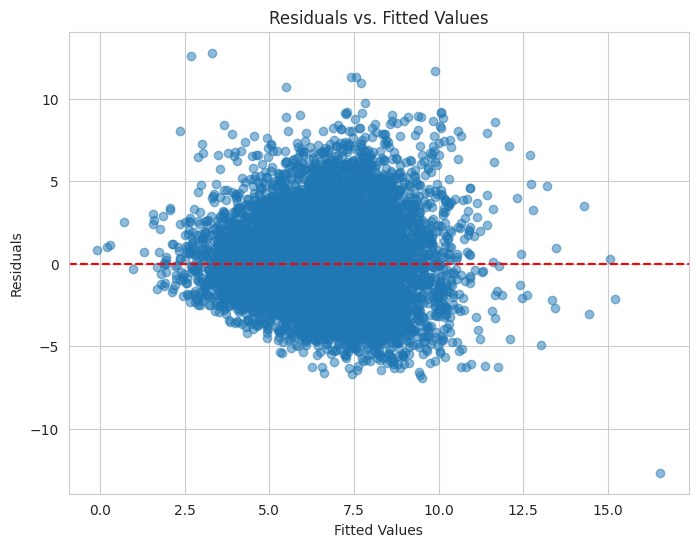

In [ ]:
X = post_eda_df.drop(columns=['datetime', 'wind_speed'])  # Input variables
y = post_eda_df['wind_speed']  # Output variable
X = sm.add_constant(X)

# Simple OLS
model = sm.OLS(y, X)
results = model.fit()

# Resids
residuals = results.resid

# Fitted
fitted_values = results.fittedvalues

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # 0 line
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

The overall residual plot looks good.

In [ ]:
def plot_scatter_against_windspeed(df, variables):
    fig, axs = plt.subplots(len(variables), 1, figsize=(8, 5 * len(variables)))
    if len(variables) == 1:
        axs = [axs]  # Ensure axs is iterable even for a single subplot
    for ax, var in zip(axs, variables):
        ax.scatter(df[var], df['wind_speed'])
        ax.set_title(f'Wind Speed vs {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Wind Speed')
    plt.tight_layout()
    return fig


Now I will perform a linear regression and plot residuals separately.

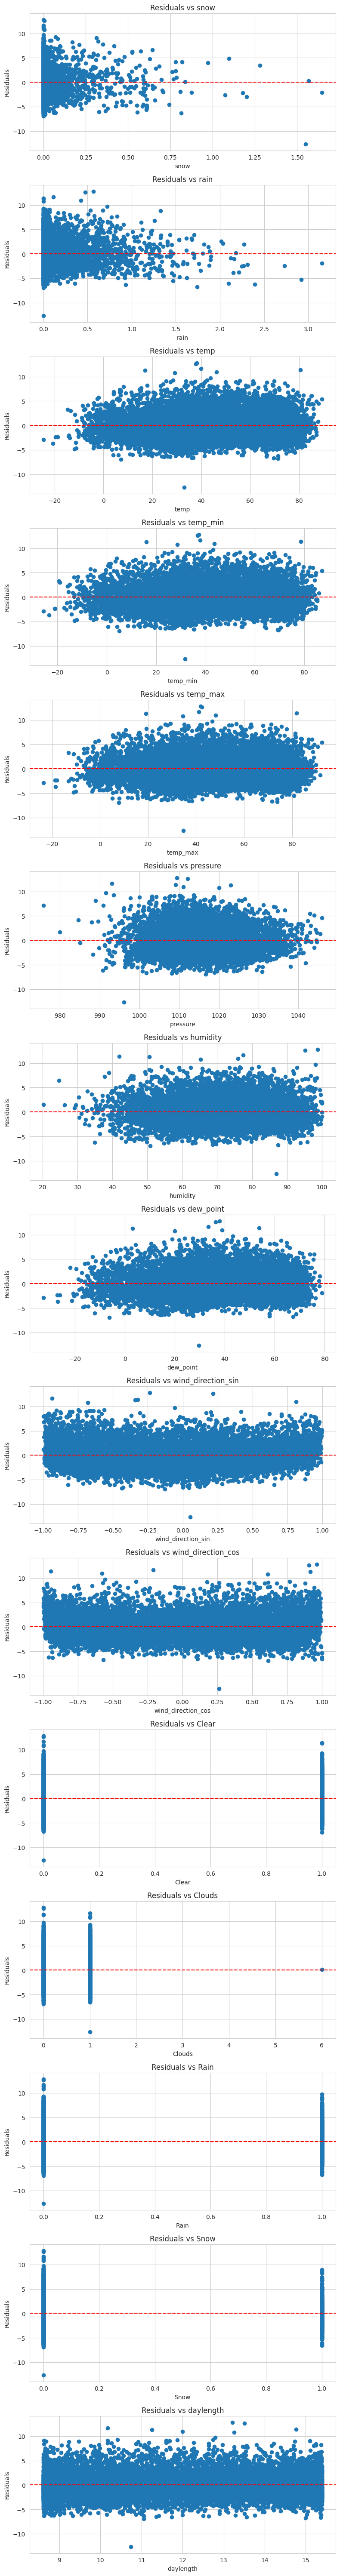

In [ ]:
X_test_data = post_eda_df.drop(columns=['datetime', 'wind_speed'])  # Exclude the target variable
y_test_data = post_eda_df['wind_speed']  # Target variable

# Fit a linear regression model for testing purposes
model_test = LinearRegression().fit(X_test_data, y_test_data)

# Function to plot residuals for all variables, adapted for the test model
def plot_residuals_for_test_model(X, y, model):
    y_pred_test = model.predict(X)
    residuals_test = y - y_pred_test
    n_vars = X.shape[1]
    fig, axs = plt.subplots(n_vars, figsize=(8, 4 * n_vars))  # Adjusted for dynamic number of variables

    if n_vars == 1:
        axs = [axs]  # Make axs iterable if there's only one subplot

    for i, var in enumerate(X.columns):
        axs[i].scatter(X[var], residuals_test)
        axs[i].set_title(f'Residuals vs {var}')
        axs[i].set_xlabel(var)
        axs[i].set_ylabel('Residuals')
        axs[i].axhline(y=0, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

# Call the function with the test data and test model
plot_residuals_for_test_model(X_test_data, y_test_data, model_test)


Not all variables may work with linear regression based on the scatter plots. However, we will see. First I will implement a stats models OLS regression to get the statistics. Then we will move on to Sci-Kit Learn models.

In [ ]:
# Prepare the data
X = post_eda_df.drop(columns=['datetime', 'wind_speed'])  # Exclude datetime and target variable
y = post_eda_df['wind_speed']  # Target variable

# Standardize the data (optional, but recommended for interpretation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add a constant term for the intercept
X_scaled_with_constant = sm.add_constant(X_scaled, prepend=True)

# Fit the OLS model
model = sm.OLS(y, X_scaled_with_constant)
results = model.fit()

# Display the summary
summary = results.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:             wind_speed   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     250.5
Date:                Wed, 17 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:33:10   Log-Likelihood:                -24268.
No. Observations:               10262   AIC:                         4.857e+04
Df Residuals:                   10246   BIC:                         4.868e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.5676      0

We'll now use the Sci Kit Learn linear regression. Results should be comparable.

In [ ]:

X = post_eda_df.drop(columns=['datetime', 'wind_speed']) # You can use this list to drop variables you do not want in the model
y = post_eda_df['wind_speed']  # Target remains the same

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on both the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculating and printing the Mean Squared Error for both sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"Training MSE: {mse_train}, Testing MSE: {mse_test} Training RMSE: {rmse_train}, Testing RMSE: {rmse_test}")


Training MSE: 6.563778063318678, Testing MSE: 6.916274168680269 Training RMSE: 2.5619871317628977, Testing RMSE: 2.629881017970256


In [ ]:
coefficients = model.coef_
intercept = model.intercept_

# R-squared for Training and Testing
r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)

# Adjusted R-squared for Training and Testing
n_train, k_train = X_train.shape
n_test, k_test = X_test.shape
adj_r_squared_train = 1 - ((1-r_squared_train)*(n_train-1)/(n_train-k_train-1))
adj_r_squared_test = 1 - ((1-r_squared_test)*(n_test-1)/(n_test-k_test-1))

# Printing summary statistics
print(f"Intercept: {intercept}")
print("Coefficients:", coefficients)
print(f"Training R-squared: {r_squared_train}")
print(f"Testing R-squared: {r_squared_test}")
print(f"Adjusted R-squared (Training): {adj_r_squared_train}")
print(f"Adjusted R-squared (Testing): {adj_r_squared_test}")

Intercept: 130.02907856799126
Coefficients: [ 5.99479761  1.30610069  0.13538749 -0.04727948 -0.58537775 -0.09612272
 -0.27350829  0.50654889 -0.45741313 -0.94537357 -0.9590638  -0.20418563
  0.66722293  1.03214002 -0.05219363]
Training R-squared: 0.2661586755976436
Testing R-squared: 0.27480553862409873
Adjusted R-squared (Training): 0.2648151360070131
Adjusted R-squared (Testing): 0.26946537322368713


Reviewing the shape of the data made me skeptical that a linear regression would effectively predict wind speed and that skepticism was well placed. The model performed best when using more of the continuous variables which was a surprise.

Since these models did not perform well, let's try some other forms of linear regression to see if there is any improvement. Below, stochastic gradient descent, lasso/ridge regressors are implemented.

In [ ]:
X = post_eda_df.drop(['wind_speed', 'datetime'], axis=1)  # Features
y = post_eda_df['wind_speed']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a pipeline that first scales the data then applies SGDRegressor - good to be in the habit
pipeline = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-8))

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 7.114773094902534
RMSE: 2.66735320025349
R^2 Score: 0.25399226280901954


In [ ]:
# Features and target variable
X = post_eda_df.drop(['wind_speed', 'datetime'], axis=1)
y = post_eda_df['wind_speed']

# Split - remaining consistent on this throughout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# SGDRegressor Pipeline
sgd_pipeline = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-8))

# Parameter grid for SGDRegressor
param_grid_sgd = {
    'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'sgdregressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# GridSearchCV for SGDRegressor
grid_search_sgd = GridSearchCV(sgd_pipeline, param_grid_sgd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor',
                                        SGDRegressor(tol=1e-08))]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'sgdregressor__learning_rate': ['constant', 'optimal',
                                                         'invscaling',
                                                         'adaptive']},
             scoring='neg_mean_squared_error')

In [ ]:
# Lasso Pipeline
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.008))

# Parameter grid for Lasso
param_grid_lasso = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}

# GridSearchCV for Lasso
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lasso.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e+04, tolerance: 7.342e+00



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(alpha=0.008))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [ ]:
# Ridge Pipeline
ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=0.08))

# Parameter grid for Ridge
param_grid_ridge = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV for Ridge
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=0.08))]),
             n_jobs=-1, param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
# Evaluating SGDRegressor
print("Best parameters for SGDRegressor:", grid_search_sgd.best_params_)
print("Best MSE for SGDRegressor:", -grid_search_sgd.best_score_)

# Evaluating Lasso with best penalty parameter
print("Best parameters for Lasso:", grid_search_lasso.best_params_)
print("Best MSE for Lasso:", -grid_search_lasso.best_score_)

# Evaluating Ridge with best penalty parameter
print("Best parameters for Ridge:", grid_search_ridge.best_params_)
print("Best MSE for Ridge:", -grid_search_ridge.best_score_)


Best parameters for SGDRegressor: {'sgdregressor__alpha': 0.0001, 'sgdregressor__learning_rate': 'adaptive'}
Best MSE for SGDRegressor: 6.600267847077435
Best parameters for Lasso: {'lasso__alpha': 0.001}
Best MSE for Lasso: 6.610439554395849
Best parameters for Ridge: {'ridge__alpha': 0.1}
Best MSE for Ridge: 6.595316871009237


In [ ]:
# Calculate R^2 scores for SGDRegressor
r2_sgd = grid_search_sgd.best_estimator_.score(X_test, y_test)
print(f"SGDRegressor - R^2 Score: {r2_sgd}")

# Calculate R^2 scores for Lasso
r2_lasso = grid_search_lasso.best_estimator_.score(X_test, y_test)
print(f"Lasso - R^2 Score: {r2_lasso}")

# Calculate R^2 scores for Ridge
r2_ridge = grid_search_ridge.best_estimator_.score(X_test, y_test)
print(f"Ridge - R^2 Score: {r2_ridge}")


SGDRegressor - R^2 Score: 0.27290287194636553
Lasso - R^2 Score: 0.2723685954277003
Ridge - R^2 Score: 0.274696165597071


In [ ]:
# Calculating RMSE for each model based on predictions made on X_test
rmse_sgd = np.sqrt(mean_squared_error(y_test, grid_search_sgd.best_estimator_.predict(X_test)))
rmse_lasso = np.sqrt(mean_squared_error(y_test, grid_search_lasso.best_estimator_.predict(X_test)))
rmse_ridge = np.sqrt(mean_squared_error(y_test, grid_search_ridge.best_estimator_.predict(X_test)))


In [ ]:
# This cell groups all of this together so we can compare side by side.
model_metrics = {
    'Model': ['SGDRegressor', 'Lasso', 'Ridge'],
    'Best Parameters': [
        str(grid_search_sgd.best_params_),
        str(grid_search_lasso.best_params_),
        str(grid_search_ridge.best_params_)
    ],
    'MSE (Cross-Validated)': [
        -grid_search_sgd.best_score_,
        -grid_search_lasso.best_score_,
        -grid_search_ridge.best_score_
    ],
    'RMSE (Test Set)': [  # Adding RMSE values here
        rmse_sgd,
        rmse_lasso,
        rmse_ridge
    ],
    'R2 Score (Test Set)': [
        r2_sgd,
        r2_lasso,
        r2_ridge
    ]
}
performance_df = pd.DataFrame(model_metrics)
performance_df

,Model,Best Parameters,MSE (Cross-Validated),RMSE (Test Set),R2 Score (Test Set)
0,SGDRegressor,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",6.600268,2.633329,0.272903
1,Lasso,{'lasso__alpha': 0.001},6.610440,2.634296,0.272369
2,Ridge,{'ridge__alpha': 0.1},6.595317,2.630079,0.274696


The good news is that our results are similar between the different types of models. The bad news is that none of them perform well. I'm not comfortagle with RMSE being this high along with that high of an R^2 score. Time to move on to a random forest regressor to see if it will perform better.

# Random Forest Regressor

In [ ]:
rf_pipeline = Pipeline([('rf', RandomForestRegressor(random_state=42))])

# Define parameter grid for Random Forest
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200, 300],  # Number of trees - you can change this
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of trees - you can change this
    #  Add more parameters here
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search_rf.best_params_)
best_mse = -grid_search_rf.best_score_
print("Best MSE from Grid Search:", best_mse)

# Predict on test set
y_pred_rf = grid_search_rf.predict(X_test)

# Calculate MSE and R2 Score for the test set
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Test MSE for Random Forest Regressor: {mse_rf}")
print(f"Test RMSE for Random Forest Regressor: {rmse_rf}")
print(f"Test R2 Score for Random Forest Regressor: {r2_rf}")





Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'rf__max_depth': 20, 'rf__n_estimators': 300}
Best MSE from Grid Search: 4.969729791336997
Test MSE for Random Forest Regressor: 5.237793166589222
Test RMSE for Random Forest Regressor: 2.288622547863501
Test R2 Score for Random Forest Regressor: 0.45079988132283033


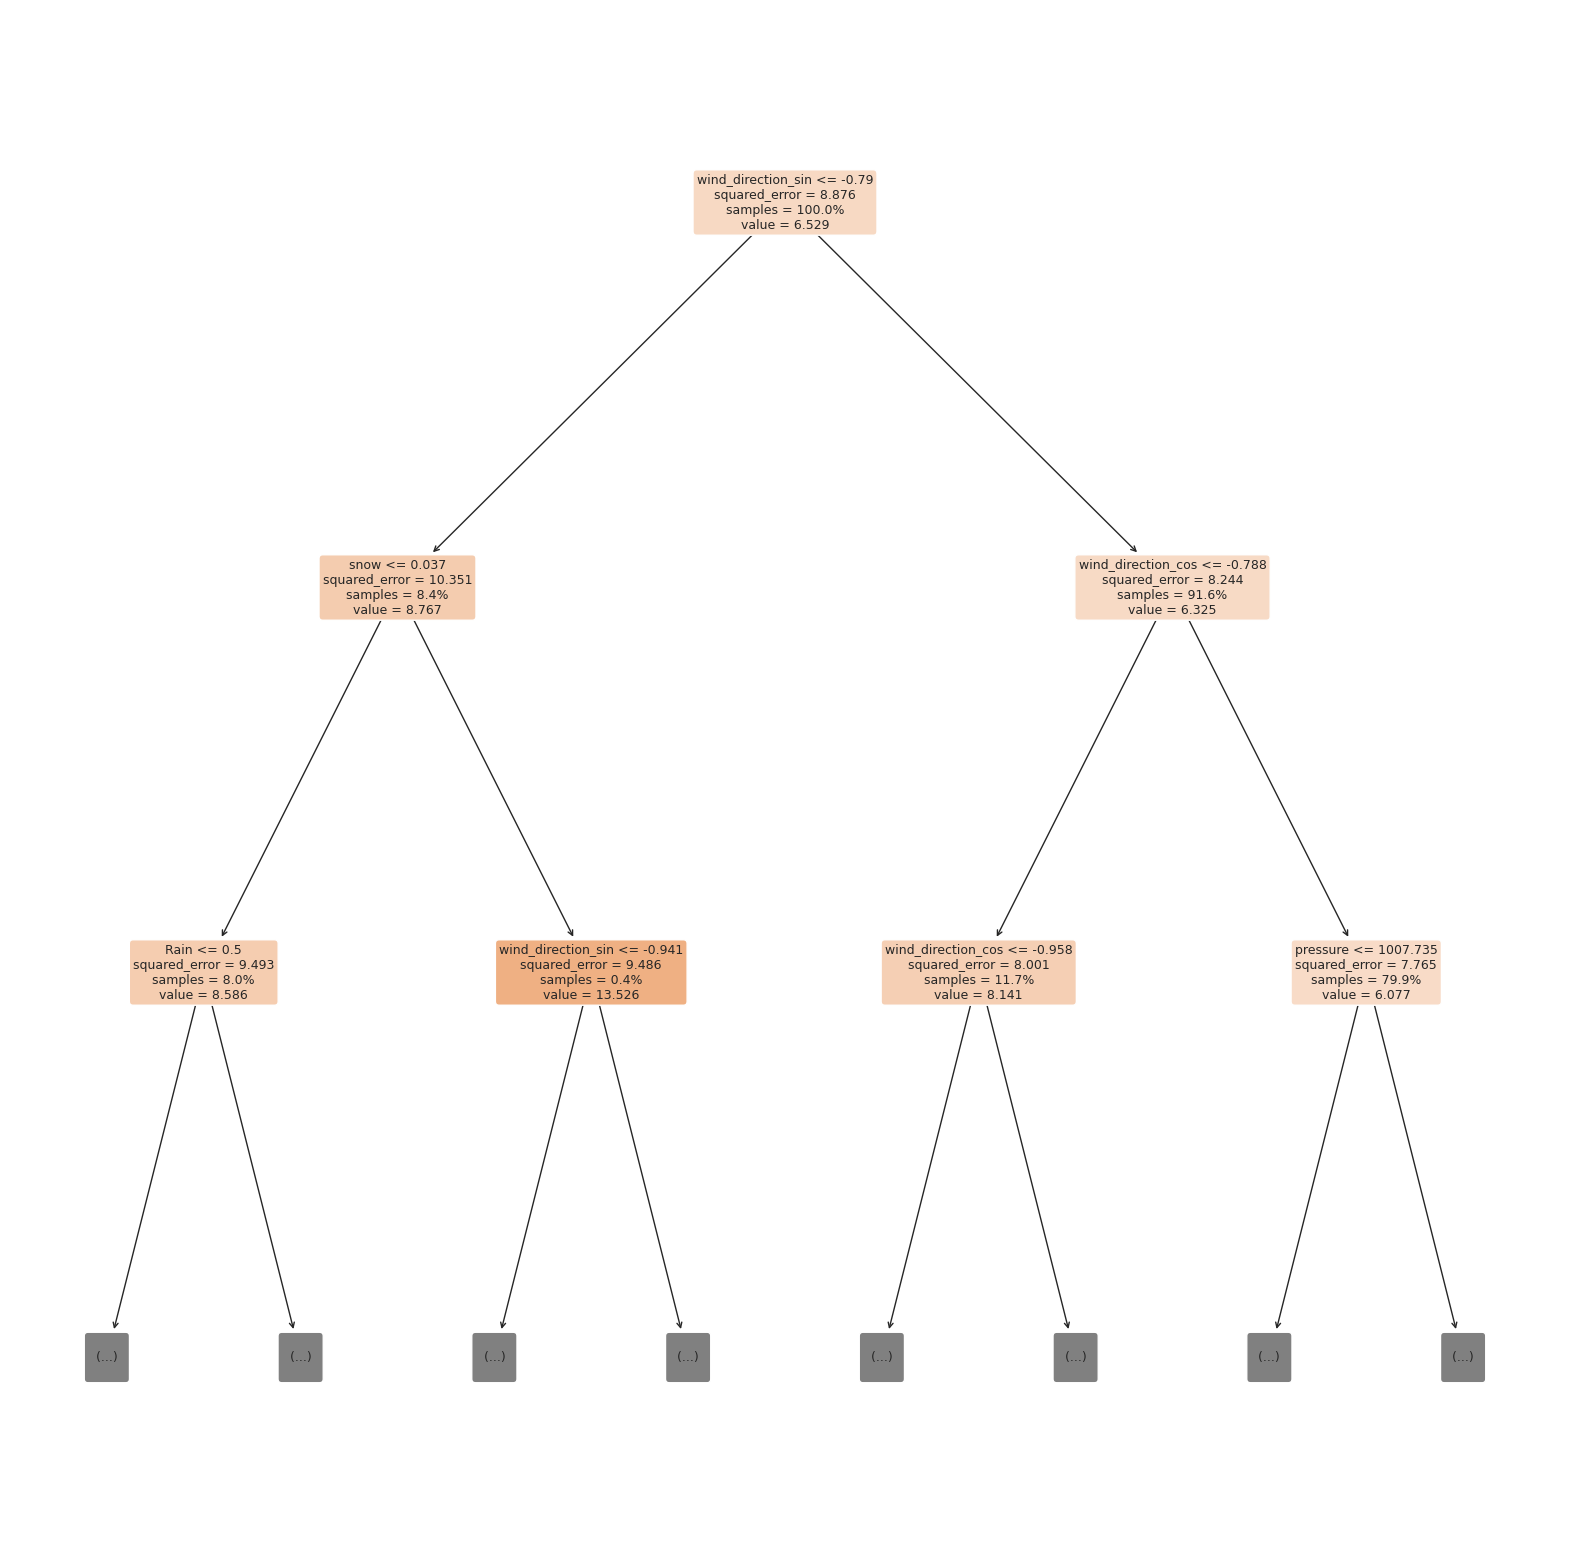

In [ ]:
best_rf_model = grid_search_rf.best_estimator_['rf']

# Select one of the trees from the best random forest model
single_tree = best_rf_model.estimators_[3]

# Visualization
plt.figure(figsize=(20, 20))
plot_tree(single_tree,
          filled=True,
          rounded=True,
          max_depth=2,  # You can adjust this based on your visualization needs
          feature_names=X_train.columns,
          proportion=True)
plt.show()


Next I will use Sci Kit learn to understand the most important features of the model.

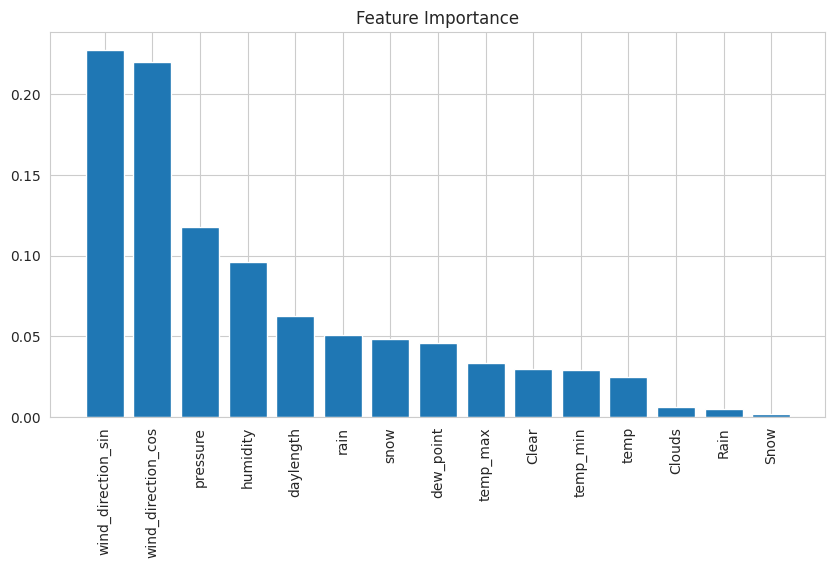

In [ ]:
best_rf_model = grid_search_rf.best_estimator_.named_steps['rf']

# Get feature importances
importances = best_rf_model.feature_importances_

# Get feature names from your DataFrame
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

#Create a plot
plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels then plot
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()


I also tried using the Select From Model feature in SK Learn. It selects a model for you based on feature importance.

In [ ]:
selector = SelectFromModel(best_rf_model, threshold="median")

# Fit to your data, then transform it
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)

# Train a new Random Forest Regressor on the transformed dataset
transformed_rf_model = RandomForestRegressor(n_estimators=best_rf_model.n_estimators,
                                             max_depth=best_rf_model.max_depth,
                                             random_state=42)
transformed_rf_model.fit(X_train_transformed, y_train)

# Predict on the transformed test set
y_pred_transformed = transformed_rf_model.predict(X_test_transformed)

# Calculate MSE and R2 Score for the test set
mse_transformed = mean_squared_error(y_test, y_pred_transformed)
rmse_transformed = np.sqrt(mse_transformed)
r2_transformed = r2_score(y_test, y_pred_transformed)

print(f"Test MSE for Transformed Random Forest Regressor: {mse_transformed}")
print(f"Test RMSE for Transformed Random Forest Regressor: {rmse_transformed}")
print(f"Test R2 Score for Transformed Random Forest Regressor: {r2_transformed}")

# To see which features were selected:
selected_features = X_train.columns[selector.get_support()]
print("Selected features:", selected_features)

Test MSE for Transformed Random Forest Regressor: 5.291182996049309
Test RMSE for Transformed Random Forest Regressor: 2.3002571586779834
Test R2 Score for Transformed Random Forest Regressor: 0.4452017792704869
Selected features: Index(['snow', 'rain', 'pressure', 'humidity', 'dew_point',
       'wind_direction_sin', 'wind_direction_cos', 'daylength'],
      dtype='object')


The model using all features performed a little better. Now we will move on to the decision tree regressor.

In [ ]:


# Pipeline again
dt_pipeline = Pipeline([('dt', DecisionTreeRegressor(random_state=42))])

# Define parameter grid for Decision Tree
param_grid_dt = {
    'dt__max_depth': [None, 10, 20, 30, 50, 100],  # You can adjust this
    'dt__min_samples_split': [2, 10, 20, 50],  # You can adjust this
    'dt__min_samples_leaf': [1, 5, 10, 20, 50]  # You can adjust this
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Best parameters and score
best_params_dt = grid_search_dt.best_params_
best_mse_dt = -grid_search_dt.best_score_

print("Best parameters for Decision Tree:", best_params_dt)
print("Best MSE from Grid Search for Decision Tree:", best_mse_dt)

# Predict on test set
y_pred_dt = grid_search_dt.predict(X_test)

# Calculate MSE, RMSE, and R2 Score for the test set
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Test MSE for Decision Tree Regressor: {mse_dt}")
print(f"Test RMSE for Decision Tree Regressor: {rmse_dt}")
print(f"Test R2 Score for Decision Tree Regressor: {r2_dt}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for Decision Tree: {'dt__max_depth': None, 'dt__min_samples_leaf': 50, 'dt__min_samples_split': 2}
Best MSE from Grid Search for Decision Tree: 6.246774592126153
Test MSE for Decision Tree Regressor: 6.415670153206856
Test RMSE for Decision Tree Regressor: 2.532917320641725
Test R2 Score for Decision Tree Regressor: 0.32729554270864303


This model did not perform as well as the random forest. However, I would like to see the most important features.

<BarContainer object of 15 artists>

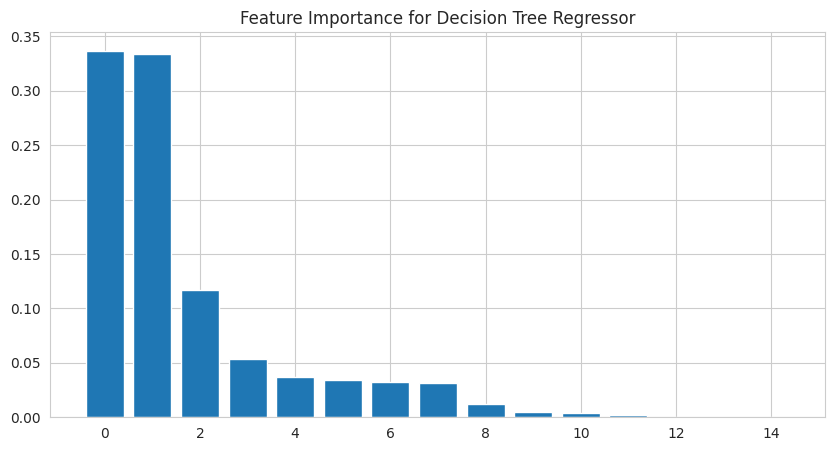

In [75]:
from sklearn.tree import plot_tree
best_dt_model = grid_search_dt.best_estimator_.named_steps['dt']
importances_dt = best_dt_model.feature_importances_
feature_names_dt = X.columns

# Sort
indices_dt = np.argsort(importances_dt)[::-1]

# Rearrange
names_dt = [feature_names_dt[i] for i in indices_dt]

# Plot
plt.figure(figsize=(10, 5))
plt.title("Feature Importance for Decision Tree Regressor")
plt.bar(range(X.shape[1]), importances_dt[indices_dt])



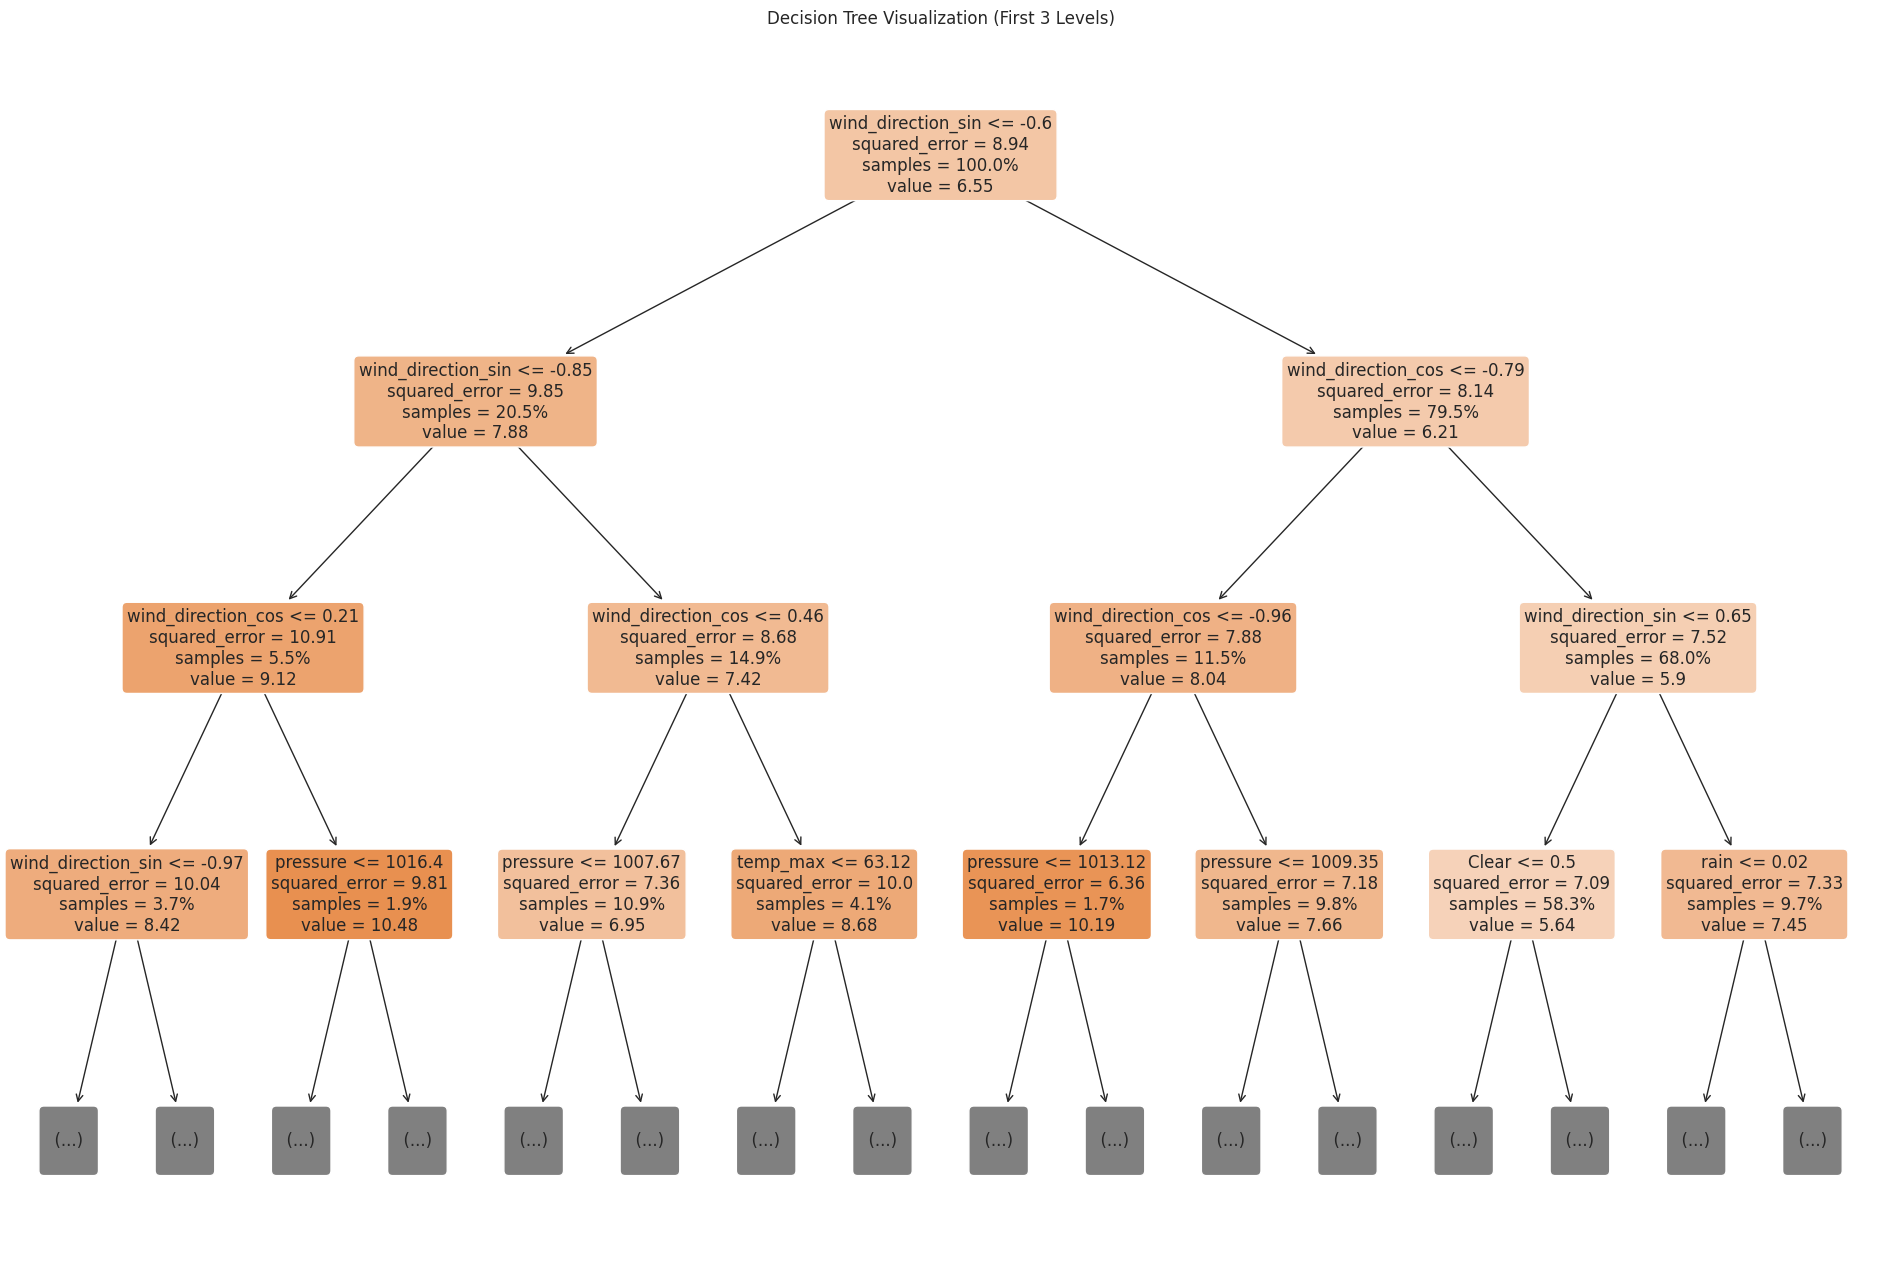

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Increase the figure size for better readability
plt.figure(figsize=(24, 16))  # Adjust the size as needed

# Plot the tree with the best settings for readability
plot_tree(best_dt_model,
          feature_names=feature_names_dt,
          filled=True,
          rounded=True,
          fontsize=12,  # Increase font size for better readability
          proportion=True,  # Show the proportion of samples at each node
          precision=2,  # Precision for floating-point numbers
          max_depth=3)  # Limit the depth of the tree to 3 levels

# Add a title to the plot
plt.title("Decision Tree Visualization (First 3 Levels)")

# Show the plot
plt.show()



At this point I've concluded the random forest regressor is the superior model with the decision tree regressor being a distant second. While I wish the model could explain more variance in wind speed, I'm happy with the improved RMSE metric along with the higher R^2 score.